In [223]:
#Loading the data
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.linalg import block_diag, expm
from scipy.spatial.transform import Rotation as Rot


g = np.array([[0],[0],[9.81]])
w = []                   #Load z_1 data 
w_true = []                   #Load z_2 data
a = []
dt = []

with open('omega.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    for line in csv_reader:
        line = [float(i) for i in line]
        w.append(line)
        
with open('a.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    for line in csv_reader:
        line = [float(i) for i in line]
        a.append(line)
        
with open('dt.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    for line in csv_reader:
        line = [float(i) for i in line]
        dt.append(line)

with open('euler_gt.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    for line in csv_reader:
        line = [float(i) for i in line]
        w_true.append(line)

    
w = np.array(w)
a = np.array(a)
dt = np.array(dt)
w_true = np.array(w_true)

print(w.shape)
print(w.shape)
print(dt.shape)
print(w_true.shape)
print(w.dtype)

(1277, 3)
(1277, 3)
(1277, 1)
(1278, 3)
float64


In [224]:
def prediction(R,w, Q, dt ):
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    
    w_cap = np.array([[0, w3, -w2], [-w3, 0, w1], [w2, -w1, 0 ]])
    m = expm(w_cap*dt)
    xt = np.matmul(R,m)
    
    P1 = np.matmul(xt,Q)
    P = np.matmul(P1,xt.T)
    return xt,P

def update(xt,P, H, N, b, y):
     #y is basially the accalaration value
        
    S1 = np.matmul(H,P)
    S = np.matmul(S1,H.T) + N
    
    S_inv = np.linalg.inv(S)
    L1 = np.matmul(P,H.T)
    L = np.matmul(L1,S_inv)
    
    #Update xt
    x1 = np.matmul(xt,y) -b
    x1 = np.matmul(L,x1)
    
    #converting x1 to wedge notation
    w1 = x1[0]
    w2 = x1[1]
    w3 = x1[2]
    
    x1_cap = np.array([[0, w3, -w2], [-w3, 0, w1], [w2, -w1, 0 ]])
    xt_updated = np.matmul(expm(x1_cap), xt)
    
    #Update P
    I = np.identity(3)
    temp = I - np.matmul(L,H)
    temp1 = np.matmul(temp, P)
    temp1 = np.matmul(temp1, temp.T)
    temp2 = np.matmul(L,N)
    temp2 = np.matmul(temp2,L.T)
    
    P_updated = temp1 + temp2
    
    return xt_updated, P_updated


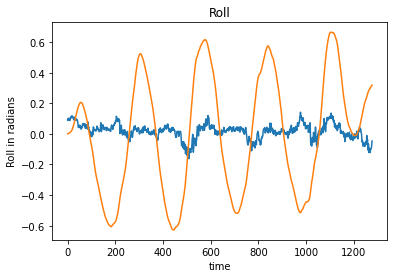

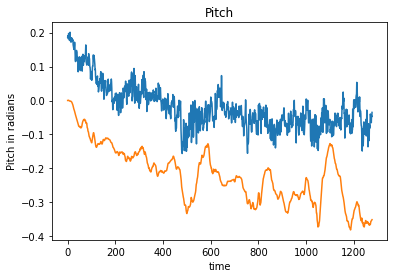

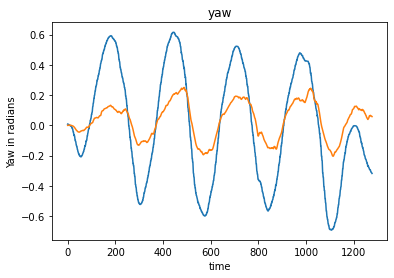

In [228]:
num_data = w.shape[0]

#Defining covariances matrix

H = np.array([[0, 9.81, 0], [-9.81, 0, 0], [0, 0, 0 ]])
R = np.identity(3)
Q = np.identity(3)*0.1
N = np.identity(3)*0.1
b = np.array([0, 0, 9.81])
theta = np.array([0, 0, 0])*0.0

t = np.zeros((num_data,3))

graph = []
XT = R
for i in range(num_data):
    
    XT, PT = prediction(XT,w[i], Q, dt[i] )
        
    XT, PT = update(XT ,PT, H, N, b, a[i])
    
    mq = Rot.from_matrix(XT)
    t[i] = mq.as_euler('xyz')

x = list(range(num_data))

plt.plot(x,t[:,0])
plt.plot(x,w_true[1:num_data+1,0])
plt.title("Roll")
plt.xlabel("time")
plt.ylabel("Roll in radians")
plt.show()

plt.plot(x,t[:,1])
plt.plot(x,w_true[1:num_data+1,1])
plt.title("Pitch")
plt.xlabel("time")
plt.ylabel("Pitch in radians")
plt.show()

plt.plot(x,t[:,2])
plt.plot(x,w_true[1:num_data+1,2])
plt.title("yaw")
plt.xlabel("time")
plt.ylabel("Yaw in radians")
plt.show()

